In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
features_sig=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [4]:
def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [63]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_bg2=load_data(features_bg2)
dataset_bg2=np.hstack((dataset_bg2,np.zeros((len(dataset_bg2),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value

In [6]:
def make_plot(pyth,sig,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",myname="mjj",myscale=5,dolog=True,donormalize=False,myloc="upper left"):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="Background",density=donormalize)
    nhmjj,_,_=plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
    plt.legend(frameon=False,fontsize=20,loc=myloc)
    plt.xlabel(r""+mylabel,fontsize=20)

    plt.tight_layout()
    plt.savefig("plots/"+myname+".pdf")
    pass

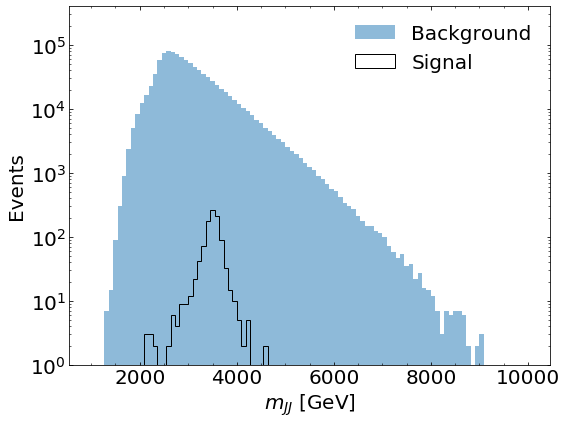

In [7]:
make_plot(1000*dataset_bg[:,0],1000*dataset_sig[:,0][0:1000],np.linspace(1000,10000,100),"$m_{JJ}$ [GeV]","mjj",myloc="upper right")

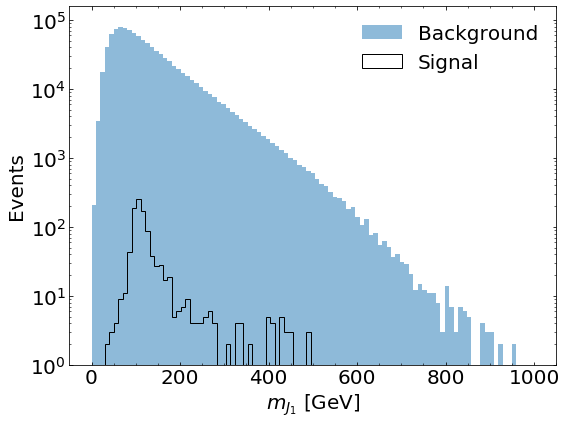

In [8]:
make_plot(1000*dataset_bg[:,1],1000*dataset_sig[:,1][0:1000],np.linspace(0,1000,100),"$m_{J_{1}}$ [GeV]","minmj",2,True,False,"upper right")

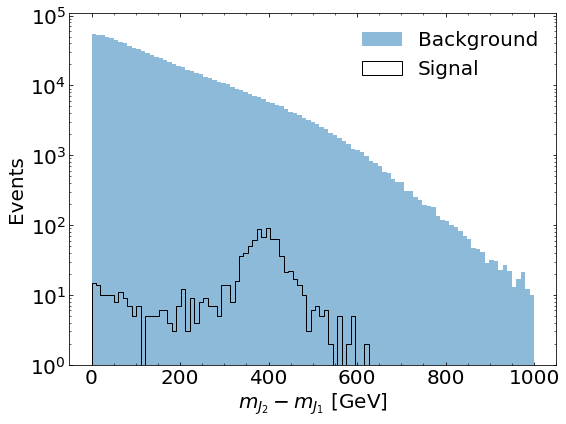

In [9]:
make_plot(1000*dataset_bg[:,2],1000*dataset_sig[:,2][0:1000],np.linspace(0,1000,100),"$m_{J_{2}}-m_{J_{1}}$ [GeV]","maxmj",2,True,False,"upper right")

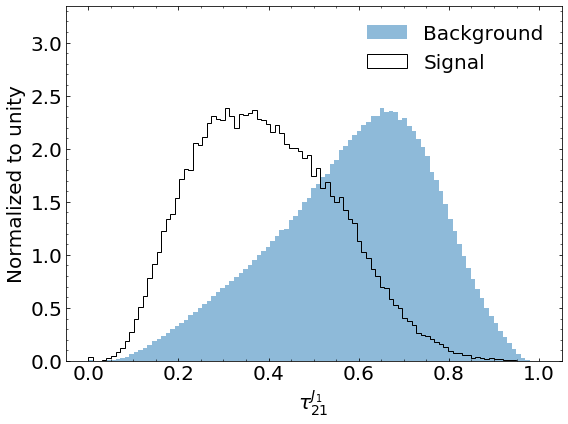

In [10]:
make_plot(dataset_bg[:,3],dataset_sig[:,3],np.linspace(0,1,100),"$\\tau_{21}^{J_{1}}$","mintau21",1.4,False,True,"upper right")

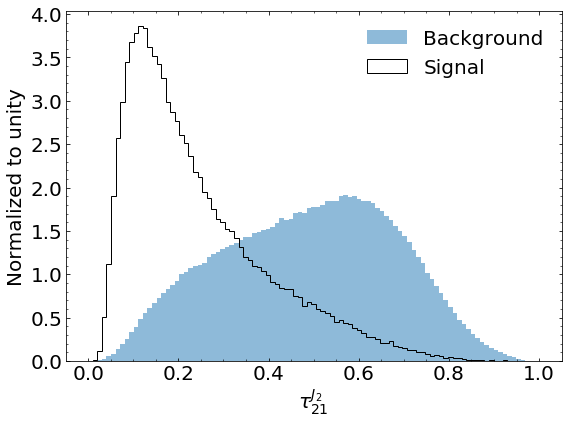

In [11]:
make_plot(dataset_bg[:,4],dataset_sig[:,4],np.linspace(0,1,100),"$\\tau_{21}^{J_{2}}$","maxtau21",2.1,False,True,"upper right")

In [12]:
from keras import backend as K
K.clear_session()

In [15]:
#Let's train a fully supervised classifier
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_bg_SR_full = dataset_bg[(dataset_bg[:,0] > SR_low)*(dataset_bg[:,0] < SR_high)][:,1:5]
X_sig_SR_full = dataset_sig[(dataset_sig[:,0] > SR_low)*(dataset_sig[:,0] < SR_high)][:,1:5]
X = np.concatenate([X_sig_SR_full,X_bg_SR_full])
Y = np.concatenate([np.ones(len(X_sig_SR_full)),np.zeros(len(X_bg_SR_full))])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [16]:
history = model.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Train on 98325 samples, validate on 98325 samples
Epoch 1/10
98325/98325 [==============================] - 6s 63us/step - loss: 0.3404 - acc: 0.8584 - val_loss: 0.2853 - val_acc: 0.8929
Epoch 2/10
98325/98325 [==============================] - 4s 37us/step - loss: 0.2553 - acc: 0.9036 - val_loss: 0.2302 - val_acc: 0.9143
Epoch 3/10
98325/98325 [==============================] - 4s 37us/step - loss: 0.2299 - acc: 0.9138 - val_loss: 0.2283 - val_acc: 0.9130
Epoch 4/10
98325/98325 [==============================] - 4s 37us/step - loss: 0.2205 - acc: 0.9166 - val_loss: 0.2274 - val_acc: 0.9152
Epoch 5/10
98325/98325 [==============================] - 4s 37us/step - loss: 0.2169 - acc: 0.9179 - val_loss: 0.2135 - val_acc: 0.9188
Epoch 6/10
98325/98325 [==============================] - 4s 37us/step - loss: 0.2149 - acc: 0.9188 - val_loss: 0.2149 - val_acc: 0.9190
Epoch 7/10
98325/98325 [==============================] - 4s 38us/step - loss: 0.2139 - acc: 0.9191 - val_loss: 0.2088 - val_acc

In [17]:
preds = model.predict(X_test,batch_size=10000)
fpr_fully, tpr_fully, _ = roc_curve(Y_test, preds)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


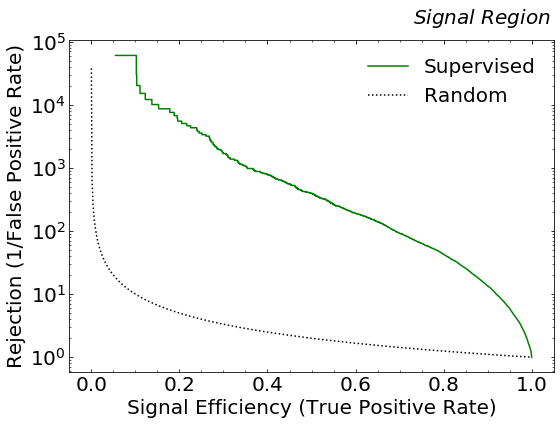

In [18]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
#plt.plot(tprs_ens[29],1./fprs_ens[29],label="CWoLa (S vs. B)",color="orange")
#plt.plot(tprs_ensSB[29],1./fprs_ensSB[29],label="CWoLa (SR vs. SB)",color="orange",ls=":")
#plt.plot(tpravg[4],1./fpravg[4],color="blue",label="ANODE")
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.text(0.73,1.9e5,r"$Signal$ $Region$",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.tight_layout()
#plt.savefig('plots/roc_unshifted.pdf',bbox_inches='tight')

In [22]:
dataset_sig_shifted = dataset_sig.copy()
dataset_bg_shifted = dataset_bg.copy()

shift = 0.

dataset_sig_shifted[:,1] = dataset_sig_shifted[:,1] + shift*dataset_sig_shifted[:,0]
dataset_sig_shifted[:,2] = dataset_sig_shifted[:,2] + shift*dataset_sig_shifted[:,0]

dataset_bg_shifted[:,1] = dataset_bg_shifted[:,1] + shift*dataset_bg_shifted[:,0]
dataset_bg_shifted[:,2] = dataset_bg_shifted[:,2] + shift*dataset_bg_shifted[:,0]

In [65]:
K.clear_session()

#Let's train a CWoLa clasifier on the shifted dataset.
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola.add(Dropout(0.1))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dropout(0.1))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dropout(0.1))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:500]
X_sig_inject2 = dataset_sig_shifted[500:1000]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_background2_inject = dataset_bg2_shifted[0:int(0.5*len(dataset_bg2))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_bg2_SB_low = X_background2_inject[(X_background2_inject[:,0] > SB_low)*(X_background2_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]
X_bg2_SB_high = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_background2_fortest = dataset_bg2_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_bg2_SB_low_test = X_background2_fortest[(X_background2_fortest[:,0] > SB_low)*(X_background2_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]
X_bg2_SB_high_test = X_background2_fortest[(X_background2_fortest[:,0] > SR_high)*(X_background2_fortest[:,0] < SB_high)][:,1:5]

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

model_cwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

Train on 126059 samples, validate on 135581 samples
Epoch 1/10
126059/126059 [==============================] - 5s 41us/step - loss: 0.6717 - acc: 0.4997 - val_loss: 0.6980 - val_acc: 0.4464
Epoch 2/10
126059/126059 [==============================] - 5s 38us/step - loss: 0.6716 - acc: 0.5016 - val_loss: 0.6911 - val_acc: 0.5525
Epoch 3/10
126059/126059 [==============================] - 5s 38us/step - loss: 0.6716 - acc: 0.4991 - val_loss: 0.6910 - val_acc: 0.5694
Epoch 4/10
126059/126059 [==============================] - 5s 39us/step - loss: 0.6716 - acc: 0.4978 - val_loss: 0.6838 - val_acc: 0.5613
Epoch 5/10
126059/126059 [==============================] - 5s 38us/step - loss: 0.6716 - acc: 0.4897 - val_loss: 0.6978 - val_acc: 0.3950
Epoch 6/10
126059/126059 [==============================] - 5s 39us/step - loss: 0.6716 - acc: 0.5022 - val_loss: 0.6870 - val_acc: 0.6475
Epoch 7/10
126059/126059 [==============================] - 5s 39us/step - loss: 0.6715 - acc: 0.5008 - val_loss: 

In [52]:
preds_hold = model_cwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_cwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_cwola, tpr_cwola, _ = roc_curve(Y_test, preds_hold)
fprSB_cwola, tprSB_cwola, _ = roc_curve(Y_testSB, predsSB, sample_weight=W_testSB)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


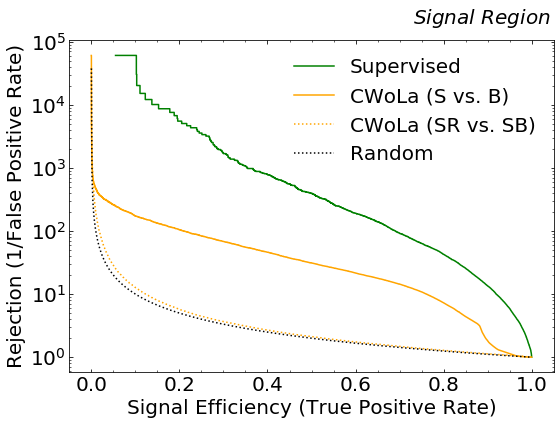

In [54]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa (S vs. B)",color="orange")
plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.text(0.73,1.9e5,r"$Signal$ $Region$",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.tight_layout()
#plt.savefig('plots/roc_unshifted.pdf',bbox_inches='tight')

In [167]:
dataset_sig_shifted = dataset_sig.copy()
dataset_bg_shifted = dataset_bg.copy()
dataset_bg2_shifted = dataset_bg2.copy()

shift = 0.1

dataset_sig_shifted[:,1] = dataset_sig_shifted[:,1] + shift*dataset_sig_shifted[:,0]
dataset_sig_shifted[:,2] = dataset_sig_shifted[:,2] + shift*dataset_sig_shifted[:,0]

dataset_bg_shifted[:,1] = dataset_bg_shifted[:,1] + shift*dataset_bg_shifted[:,0]
dataset_bg_shifted[:,2] = dataset_bg_shifted[:,2] + shift*dataset_bg_shifted[:,0]

dataset_bg2_shifted[:,1] = dataset_bg2_shifted[:,1] + shift*dataset_bg2_shifted[:,0]
dataset_bg2_shifted[:,2] = dataset_bg2_shifted[:,2] + shift*dataset_bg2_shifted[:,0]

In [168]:
#CWoLa
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_sacwola = Sequential()
model_sacwola.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(1, activation='sigmoid'))
model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:500]
X_sig_inject2 = dataset_sig_shifted[500:1000]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

mylambda = 0.5

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_sacwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_sacwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_sacwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_test, preds_hold)
fprSB_sacwola, tprSB_sacwola, _ = roc_curve(Y_testSB, predsSB, sample_weight=W_testSB)

###

mylambda = 0.

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_cwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_cwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_cwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_cwola, tpr_cwola, _ = roc_curve(Y_test, preds_hold)
fprSB_cwola, tprSB_cwola, _ = roc_curve(Y_testSB, predsSB, sample_weight=W_testSB)

Train on 252674 samples, validate on 135581 samples
Epoch 1/10
252674/252674 [==============================] - 11s 44us/step - loss: 0.1665 - acc: 0.4968 - val_loss: 0.6834 - val_acc: 0.5525
Epoch 2/10
252674/252674 [==============================] - 9s 37us/step - loss: 0.1664 - acc: 0.4917 - val_loss: 0.6686 - val_acc: 0.8026
Epoch 3/10
252674/252674 [==============================] - 9s 37us/step - loss: 0.1664 - acc: 0.4993 - val_loss: 0.6767 - val_acc: 0.7769
Epoch 4/10
252674/252674 [==============================] - 9s 37us/step - loss: 0.1663 - acc: 0.4967 - val_loss: 0.6692 - val_acc: 0.5525
Epoch 5/10
252674/252674 [==============================] - 9s 38us/step - loss: 0.1663 - acc: 0.4916 - val_loss: 0.6899 - val_acc: 0.5171
Epoch 6/10
252674/252674 [==============================] - 10s 38us/step - loss: 0.1664 - acc: 0.5027 - val_loss: 0.6388 - val_acc: 0.5525
Epoch 7/10
252674/252674 [==============================] - 10s 38us/step - loss: 0.1663 - acc: 0.4900 - val_los

In [169]:
#Optimal CWoLa

model_cwola_optimal = Sequential()
model_cwola_optimal.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(1, activation='sigmoid'))
model_cwola_optimal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Train on 121742 samples, validate on 135581 samples
Epoch 1/10
121742/121742 [==============================] - 7s 59us/step - loss: 0.6933 - acc: 0.5014 - val_loss: 0.6836 - val_acc: 0.7969
Epoch 2/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6848 - val_acc: 0.8228
Epoch 3/10
121742/121742 [==============================] - 5s 45us/step - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6835 - val_acc: 0.7993
Epoch 4/10
121742/121742 [==============================] - 5s 43us/step - loss: 0.6931 - acc: 0.5038 - val_loss: 0.6890 - val_acc: 0.5525
Epoch 5/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5026 - val_loss: 0.6719 - val_acc: 0.5525
Epoch 6/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5009 - val_loss: 0.6817 - val_acc: 0.8427
Epoch 7/10
121742/121742 [==============================] - 5s 44us/step - loss: 0.6931 - acc: 0.5029 - val_loss: 

In [170]:
preds_hold = model_cwola_optimal.predict(X_test,batch_size=10000)[:,0]
fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_test, preds_hold)

In [171]:
#SALAD

model_reweighter = Sequential()
model_reweighter.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(1, activation='sigmoid'))
model_reweighter.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_sig_SB_low_long = X_sig_inject[(X_sig_inject[:,0] > SB_low_long)*(X_sig_inject[:,0] < SR_low)][:,0:5]
X_sig_SB_high_long = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high_long)][:,0:5]
X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train_forw = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,0:5]

preds = model_reweighter.predict(np.concatenate([X_sig_SR_train_forw,X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_sig_SR_train_forw)),np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad = Sequential()
model_salad.add(Dense(64, input_dim=4, activation='relu')) 
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(1, activation='sigmoid'))
model_salad.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_datavsim = Sequential()
model_datavsim.add(Dense(64, input_dim=4, activation='relu')) 
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(1, activation='sigmoid'))
model_datavsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=weights_salad)
model_datavsim.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Epoch 1/30
361941/361941 [==============================] - 13s 36us/step - loss: 0.6854 - acc: 0.5498
Epoch 2/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6834 - acc: 0.5564
Epoch 3/30
361941/361941 [==============================] - 11s 32us/step - loss: 0.6827 - acc: 0.5582
Epoch 4/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6821 - acc: 0.5602
Epoch 5/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6817 - acc: 0.5606
Epoch 6/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6815 - acc: 0.5602
Epoch 7/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6814 - acc: 0.5613
Epoch 8/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6812 - acc: 0.5613
Epoch 9/30
361941/361941 [==============================] - 12s 32us/step - loss: 0.6811 - acc: 0.5612
Epoch 10/30
361941/361941 [==============================] - 12s 32us/ste

In [172]:
ww = model_reweighter.predict(X_bg2_SR_train_forw,batch_size=10000)
ww = ww / (1.-ww)

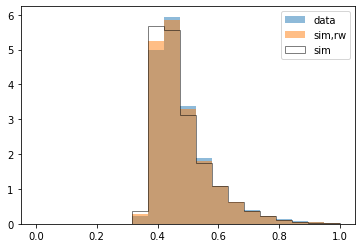

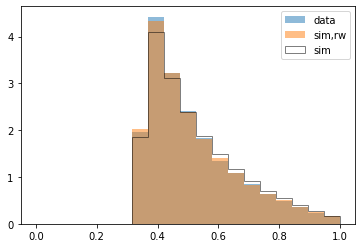

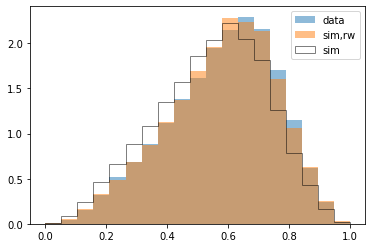

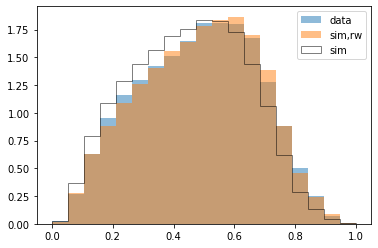

In [173]:
for i in range(1,5):
    plt.figure()
    plt.hist(X_bg_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="data")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,weights=ww,density=True,label="sim,rw")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,histtype="step",color="black",label="sim")
    plt.legend(frameon=True)

In [174]:
preds_hold = model_salad.predict(X_test,batch_size=10000)[:,0]
fpr_salad, tpr_salad, _ = roc_curve(Y_test, preds_hold)

In [178]:
preds_hold = model_datavsim.predict(X_test,batch_size=10000)[:,0]
fpr_datavsim, tpr_datavsim, _ = roc_curve(Y_test, preds_hold)

In [175]:
#Let's train a fully supervised classifier
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Xfully_train = np.concatenate([X_sig_SR_train,X_bg_SR_train])
#Yfully_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train))])

model.fit(X_test,Y_test, epochs=10, batch_size=200,validation_data=(X_test,Y_test))
preds = model.predict(X_test,batch_size=10000)
fpr_fully, tpr_fully, _ = roc_curve(Y_test, preds)

Train on 135581 samples, validate on 135581 samples
Epoch 1/10
135581/135581 [==============================] - 8s 63us/step - loss: 0.3472 - acc: 0.8616 - val_loss: 0.3112 - val_acc: 0.8747
Epoch 2/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.3108 - acc: 0.8749 - val_loss: 0.3045 - val_acc: 0.8778
Epoch 3/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2980 - acc: 0.8800 - val_loss: 0.2903 - val_acc: 0.8837
Epoch 4/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2727 - acc: 0.8915 - val_loss: 0.2764 - val_acc: 0.8868
Epoch 5/10
135581/135581 [==============================] - 6s 48us/step - loss: 0.2584 - acc: 0.8964 - val_loss: 0.2529 - val_acc: 0.8989
Epoch 6/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2515 - acc: 0.8994 - val_loss: 0.2425 - val_acc: 0.9031
Epoch 7/10
135581/135581 [==============================] - 6s 47us/step - loss: 0.2481 - acc: 0.9014 - val_loss: 

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divi

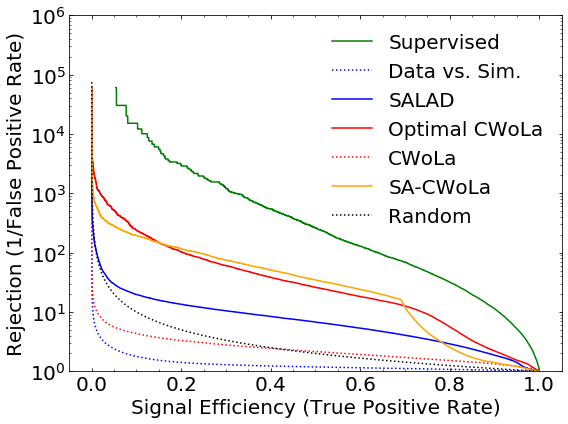

In [195]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
plt.plot(tpr_datavsim,1./fpr_datavsim,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,1./fpr_salad,label="SALAD",color="blue")
plt.plot(tpr_ocwola,1./fpr_ocwola,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,1./fpr_sacwola,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.ylim([1,1e6])
plt.tight_layout()
plt.savefig('SA-CWoLa/roc_shifted.pdf',bbox_inches='tight')

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: Runtim

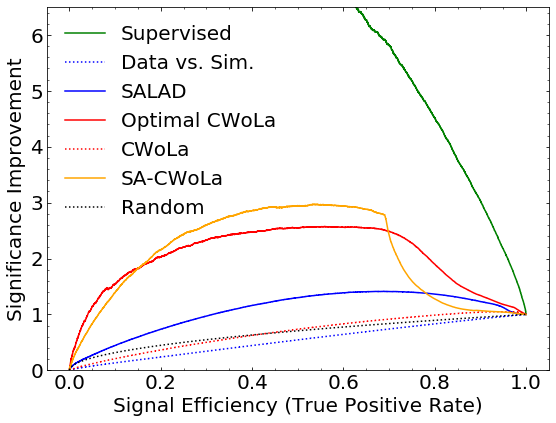

In [194]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,tpr_fully/fpr_fully**0.5,label="Supervised",color="green")
plt.plot(tpr_datavsim,tpr_datavsim/fpr_datavsim**0.5,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,tpr_salad/fpr_salad**0.5,label="SALAD",color="blue")
plt.plot(tpr_ocwola,tpr_ocwola/fpr_ocwola**0.5,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,tpr_cwola/fpr_cwola**0.5,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,tpr_sacwola/fpr_sacwola**0.5,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,tpr_fully/tpr_fully**0.5,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance Improvement",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.tight_layout()
plt.ylim([0,6.5])
plt.savefig('SA-CWoLa/sic_shifted.pdf',bbox_inches='tight')

In [3]:
def computemjj_np(event):
    px1 = event[:,0]
    py1 = event[:,1]
    pz1 = event[:,2]
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[:,3]**2)
    
    px2 = event[:,7]
    py2 = event[:,8]
    pz2 = event[:,9]
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[:,10]**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.sqrt(m2)

In [4]:
signal_np = signal.to_numpy()
pythia_np = pythia.to_numpy()
herwig_np = herwig.to_numpy()

In [5]:
mjj_signal = computemjj_np(signal_np)
mjj_pythia = computemjj_np(pythia_np)
mjj_herwig = computemjj_np(herwig_np)

First thing to do is to make some plots of the basic features.

In [6]:
minmass_pythia = np.array(pythia[['mj1','mj2']].min(axis=1))
maxmass_pythia = np.array(pythia[['mj1','mj2']].max(axis=1))
minmass_herwig = np.array(herwig[['mj1','mj2']].min(axis=1))
maxmass_herwig = np.array(herwig[['mj1','mj2']].max(axis=1))
minmass_signal = np.array(signal[['mj1','mj2']].min(axis=1))
maxmass_signal = np.array(signal[['mj1','mj2']].max(axis=1))

In [7]:
tau21A_pythia = pythia_np[:,5]/(0.00001+pythia_np[:,4])
tau21B_pythia = pythia_np[:,12]/(0.00001+pythia_np[:,11])
m1_pythia = pythia_np[:,3]
m2_pythia = pythia_np[:,10]
mymasses_pythia = np.concatenate((np.reshape(m1_pythia,[len(m1_pythia),1]),np.reshape(m2_pythia,[len(m2_pythia),1])),axis=1)
mytaus_pythia = np.concatenate((np.reshape(tau21A_pythia,[len(tau21A_pythia),1]),np.reshape(tau21B_pythia,[len(tau21B_pythia),1])),axis=1)
order_pythia = [np.argmax(mymasses_pythia[i]) for i in range(len(mymasses_pythia))]
tau21a_pythia = [mytaus_pythia[i][order_pythia[i]] for i in range(len(order_pythia))]
tau21b_pythia = [mytaus_pythia[i][1-order_pythia[i]] for i in range(len(order_pythia))]

tau21A_herwig = herwig_np[:,5]/(0.00001+herwig_np[:,4])
tau21B_herwig = herwig_np[:,12]/(0.00001+herwig_np[:,11])
m1_herwig = herwig_np[:,3]
m2_herwig = herwig_np[:,10]
mymasses_herwig = np.concatenate((np.reshape(m1_herwig,[len(m1_herwig),1]),np.reshape(m2_herwig,[len(m2_herwig),1])),axis=1)
mytaus_herwig = np.concatenate((np.reshape(tau21A_herwig,[len(tau21A_herwig),1]),np.reshape(tau21B_herwig,[len(tau21B_herwig),1])),axis=1)
order_herwig = [np.argmax(mymasses_herwig[i]) for i in range(len(mymasses_herwig))]
tau21a_herwig = [mytaus_herwig[i][order_herwig[i]] for i in range(len(order_herwig))]
tau21b_herwig = [mytaus_herwig[i][1-order_herwig[i]] for i in range(len(order_herwig))]

tau21A_signal = signal_np[:,5]/(0.00001+signal_np[:,4])
tau21B_signal = signal_np[:,12]/(0.00001+signal_np[:,11])
m1_signal = signal_np[:,3]
m2_signal = signal_np[:,10]
mymasses_signal = np.concatenate((np.reshape(m1_signal,[len(m1_signal),1]),np.reshape(m2_signal,[len(m2_signal),1])),axis=1)
mytaus_signal = np.concatenate((np.reshape(tau21A_signal,[len(tau21A_signal),1]),np.reshape(tau21B_signal,[len(tau21B_signal),1])),axis=1)
order_signal = [np.argmax(mymasses_signal[i]) for i in range(len(mymasses_signal))]
tau21a_signal = [mytaus_signal[i][order_signal[i]] for i in range(len(order_signal))]
tau21b_signal = [mytaus_signal[i][1-order_signal[i]] for i in range(len(order_signal))]

Now, let's prepare the ML input

In [8]:
def rs(x):
    return np.reshape(x,[len(x),1])

In [9]:
x_signal = np.concatenate((rs(maxmass_signal)/1000.,rs(minmass_signal)/1000.,rs(tau21a_signal),rs(tau21b_signal)),axis=1)
x_data = np.concatenate((rs(maxmass_pythia + 0.1*mjj_pythia)/1000.,rs(minmass_pythia + 0.1*mjj_pythia)/1000.,rs(tau21a_pythia),rs(tau21b_pythia)),axis=1)
x_MC = np.concatenate((rs(maxmass_herwig + 0.1*mjj_herwig)/1000.,rs(minmass_herwig + 0.1*mjj_herwig)/1000.,rs(tau21a_herwig),rs(tau21b_herwig)),axis=1)

In [10]:
SR_low = 3250
SR_high = 3750

SB_low = 3250-250
SB_high = 3750+250

In [11]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

In [12]:
print(len(x_SR_data))
print(len(x_SB_data))

152668
170647


0.0
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 14s 43us/step - loss: 0.6786 - acc: 0.5415 - val_loss: 0.6714 - val_acc: 0.5542
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6634 - acc: 0.5570 - val_loss: 0.6616 - val_acc: 0.5500
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6624 - acc: 0.5592 - val_loss: 0.6608 - val_acc: 0.5575
Epoch 4/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6620 - acc: 0.5607 - val_loss: 0.6672 - val_acc: 0.5578
Epoch 5/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6607 - acc: 0.5620 - val_loss: 0.6639 - val_acc: 0.5605
Epoch 6/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6605 - acc: 0.5621 - val_loss: 0.6617 - val_acc: 0.5605
Epoch 7/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6607 - acc: 0.5640 -

Epoch 18/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.2638 - acc: 0.5620 - val_loss: 0.2628 - val_acc: 0.5681
Epoch 19/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2634 - acc: 0.5643 - val_loss: 0.2633 - val_acc: 0.5660
Epoch 20/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2635 - acc: 0.5612 - val_loss: 0.2633 - val_acc: 0.5619
0.2 0.6014771088836305
0.3
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 12s 37us/step - loss: 0.2402 - acc: 0.5313 - val_loss: 0.2344 - val_acc: 0.5374
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2348 - acc: 0.5461 - val_loss: 0.2341 - val_acc: 0.5504
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2324 - acc: 0.5560 - val_loss: 0.2309 - val_acc: 0.5547
Epoch 4/20
323877/323877 [==============================] - 11s 35us/step - lo

323877/323877 [==============================] - 12s 37us/step - loss: -0.0392 - acc: 0.5372 - val_loss: -0.0241 - val_acc: 0.5278
Epoch 11/20
323877/323877 [==============================] - 12s 36us/step - loss: -0.0388 - acc: 0.5385 - val_loss: -0.0489 - val_acc: 0.5289
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0410 - acc: 0.5376 - val_loss: -0.0447 - val_acc: 0.5301
Epoch 13/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0408 - acc: 0.5379 - val_loss: -0.0294 - val_acc: 0.5273
Epoch 14/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0440 - acc: 0.5393 - val_loss: -0.0466 - val_acc: 0.5339
Epoch 15/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0455 - acc: 0.5359 - val_loss: -0.0501 - val_acc: 0.5306
Epoch 16/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0472 - acc: 0.5384 - val_loss: 0.0108 - val_acc: 0.5322
Epoch 17/20


Epoch 6/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 7/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 9/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 10/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 11/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epo

323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 3/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 4/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 5/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 6/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 7/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 9/20
323877

323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 15/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 16/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 17/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 18/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 19/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 20/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
1.9 0.5
2.0

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


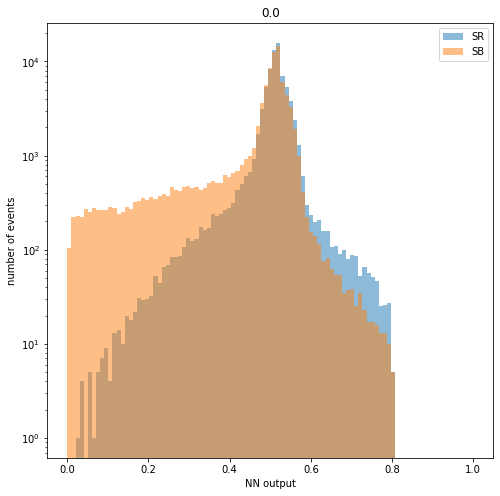

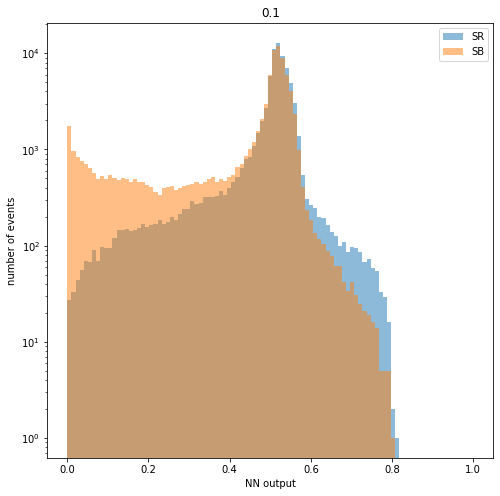

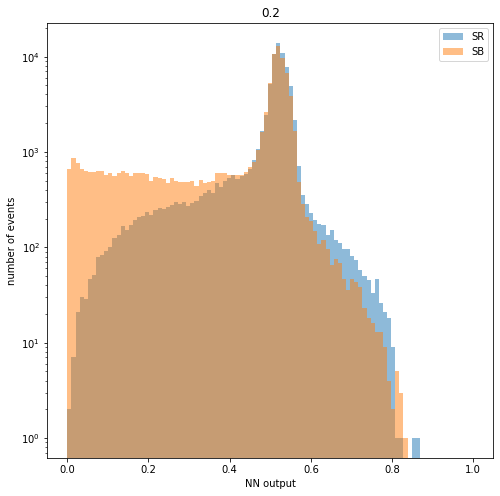

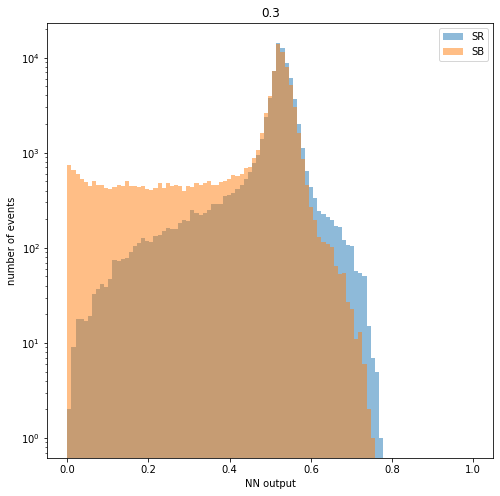

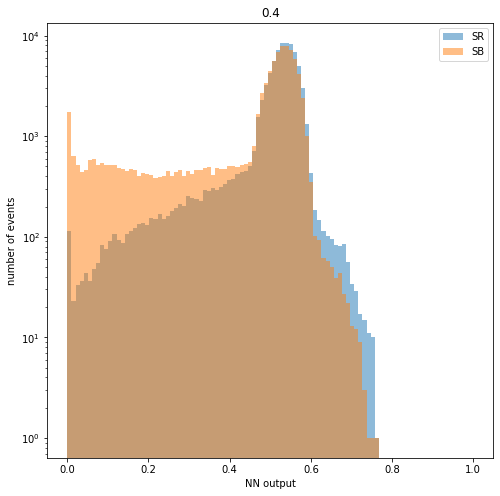

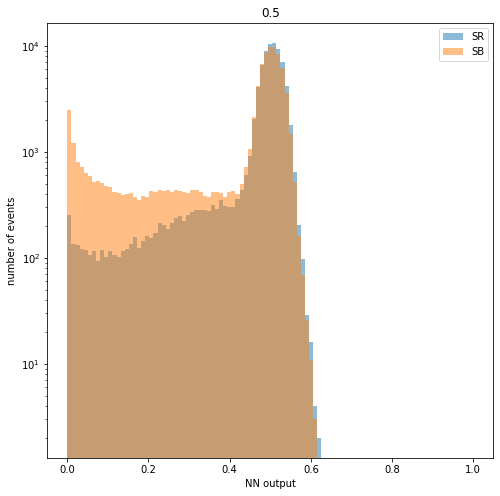

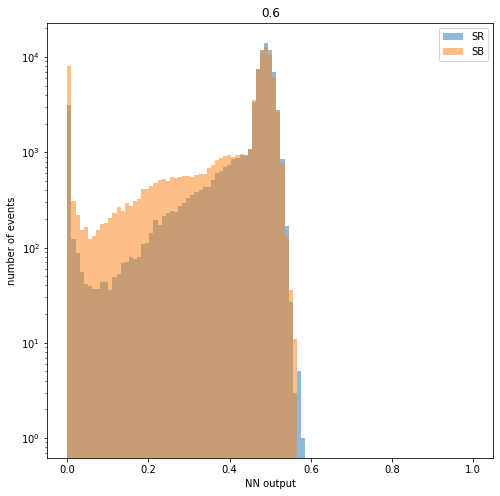

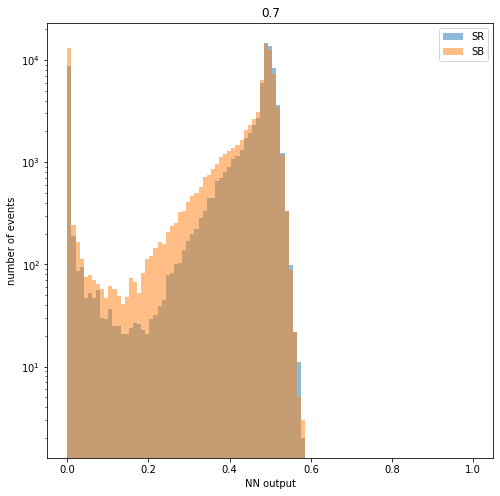

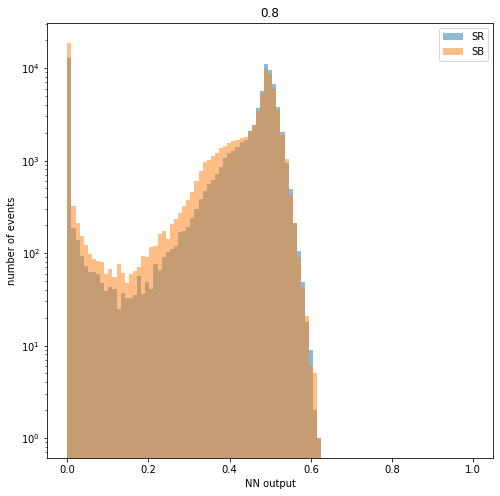

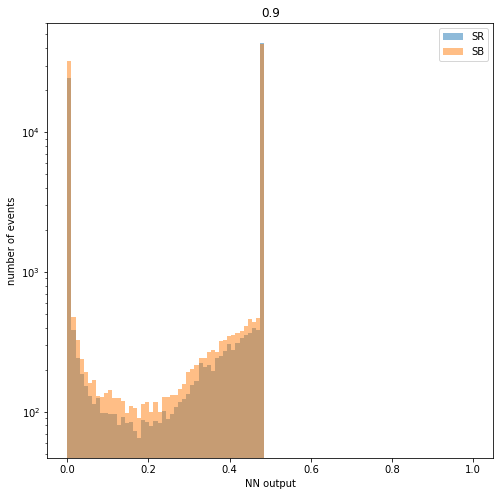

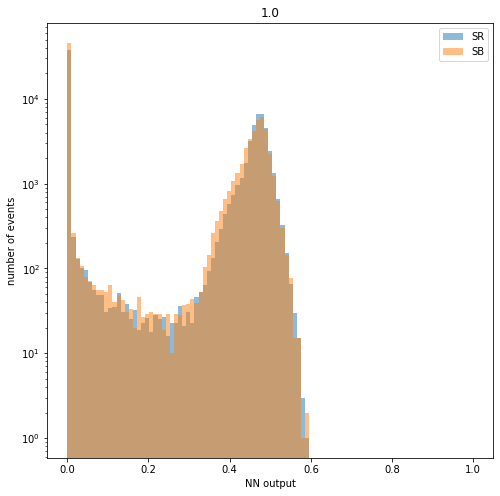

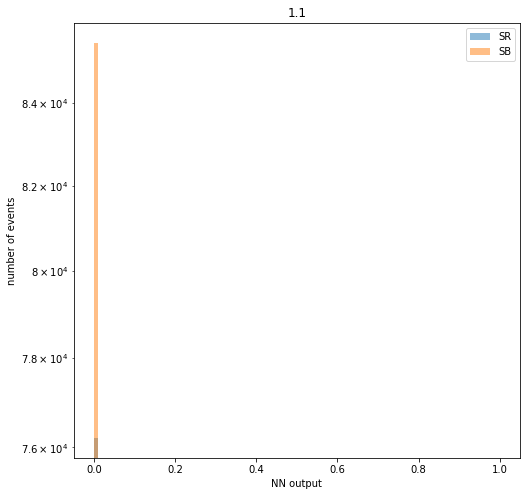

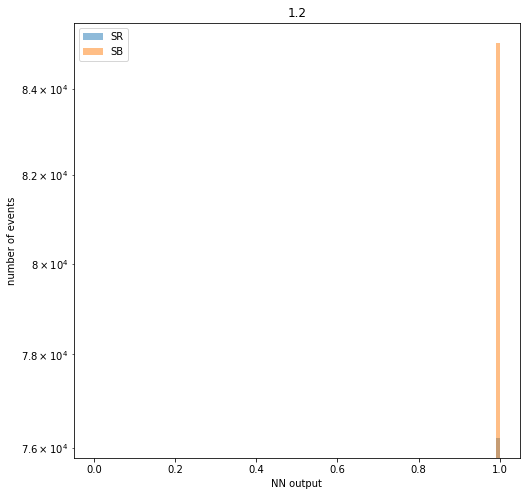

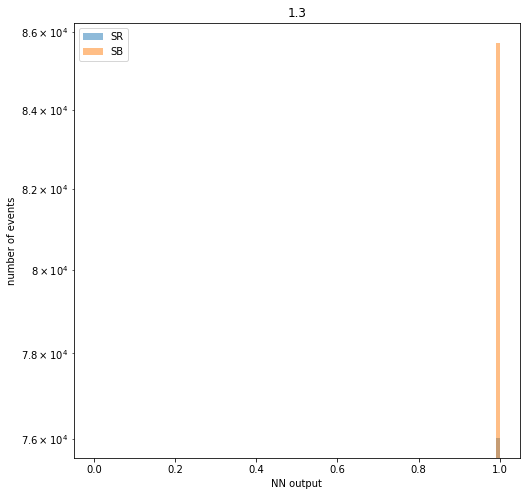

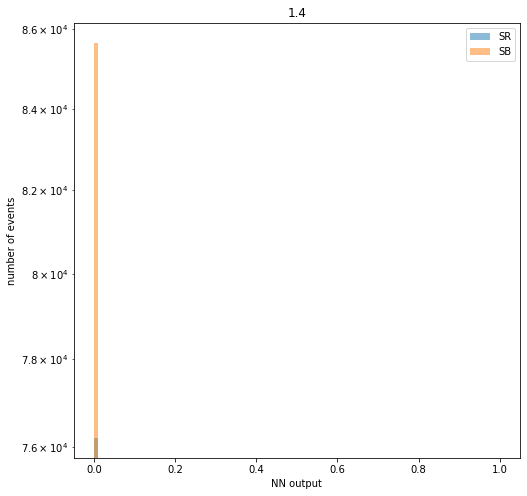

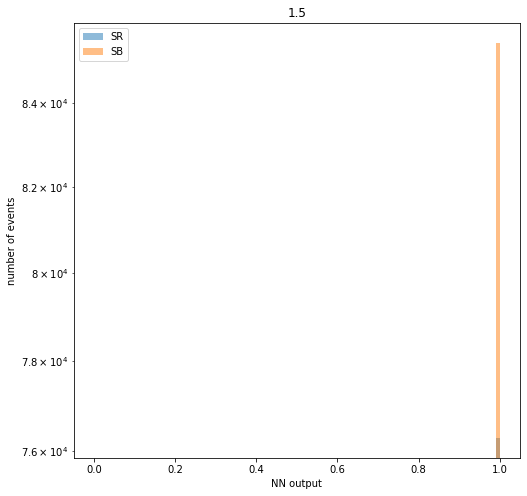

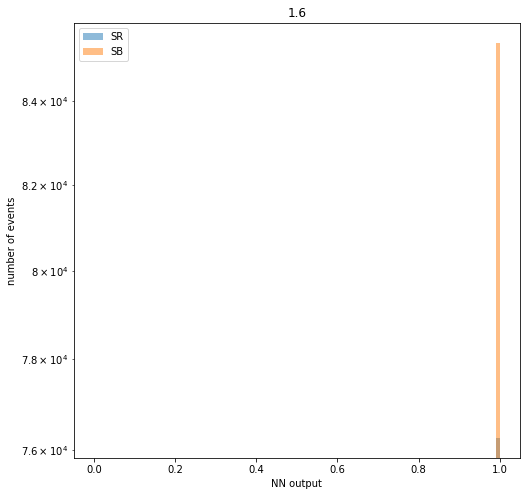

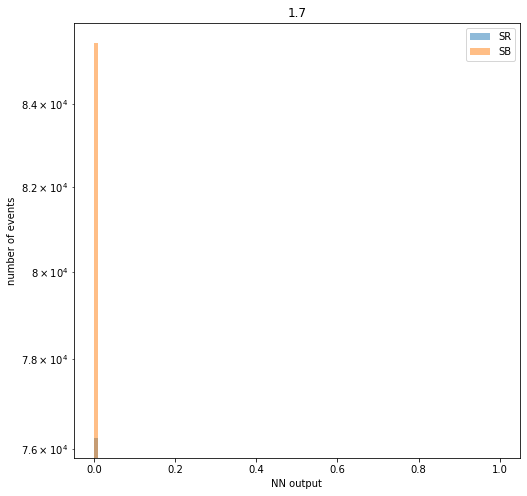

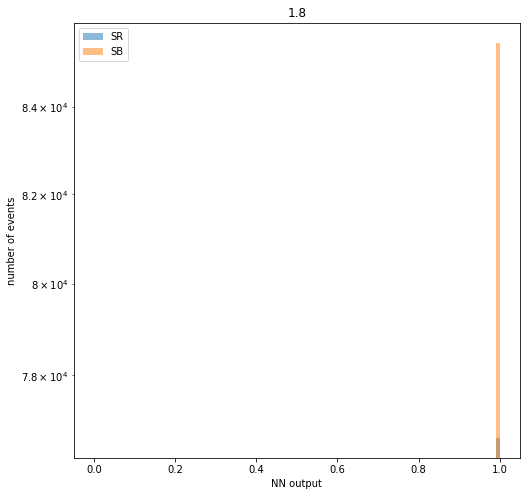

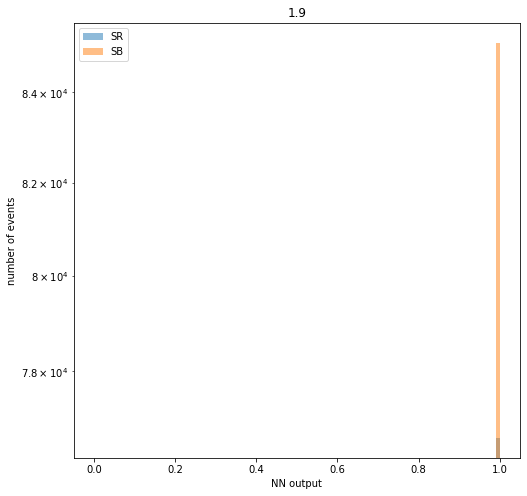

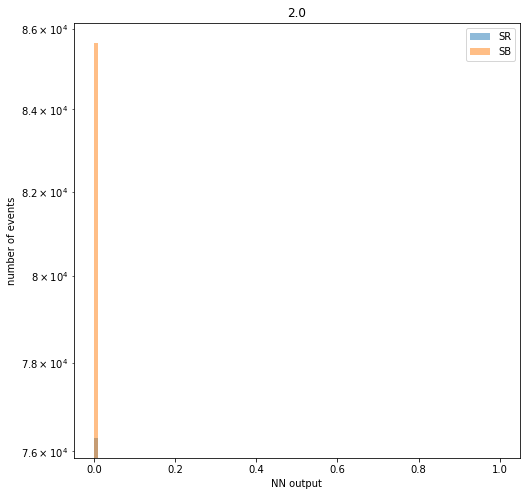

In [13]:
myaucs = []
histories = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    
    print(mylambda)

    X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC))])
    W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))
    histories+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)
    
    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()


Text(0.5, 0, '$\\lambda$')

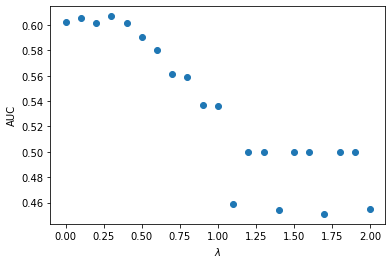

In [14]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")

In [15]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

x_SB_low_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)]
x_SB_high_data = x_data[(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]

In [16]:
print(len(x_SB_low_data))
print(len(x_SB_high_data))
print(len(x_SR_data))

127601
43046
152668


1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 11s 44us/step - loss: 0.6439 - acc: 0.5005 - val_loss: 0.6334 - val_acc: 0.4951
Epoch 2/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6281 - acc: 0.5305 - val_loss: 0.6241 - val_acc: 0.5274
Epoch 3/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6267 - acc: 0.5335 - val_loss: 0.6245 - val_acc: 0.5250
Epoch 4/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6252 - acc: 0.5338 - val_loss: 0.6274 - val_acc: 0.5479
Epoch 5/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6251 - acc: 0.5335 - val_loss: 0.6297 - val_acc: 0.5124
Epoch 6/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6249 - acc: 0.5329 - val_loss: 0.6236 - val_acc: 0.5233
Epoch 7/20
246981/246981 [=====================

246981/246981 [==============================] - 10s 39us/step - loss: -0.3089 - acc: 0.4932 - val_loss: -0.3496 - val_acc: 0.4787
Epoch 12/20
246981/246981 [==============================] - 10s 41us/step - loss: -0.2945 - acc: 0.4942 - val_loss: -0.3576 - val_acc: 0.4997
Epoch 13/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3004 - acc: 0.4938 - val_loss: -0.3290 - val_acc: 0.5023
Epoch 14/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.2939 - acc: 0.4958 - val_loss: -0.3456 - val_acc: 0.5036
Epoch 15/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3038 - acc: 0.4941 - val_loss: -0.3337 - val_acc: 0.5219
Epoch 16/20
246981/246981 [==============================] - 10s 40us/step - loss: -0.3036 - acc: 0.4944 - val_loss: -0.2234 - val_acc: 0.5414
Epoch 17/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3006 - acc: 0.4946 - val_loss: -0.2650 - val_acc: 0.4677
Epoch 18/20

246981/246981 [==============================] - 11s 43us/step - loss: -3.0234 - acc: 0.4890 - val_loss: -3.0269 - val_acc: 0.4950
1.0 0.578367982774179
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 13s 51us/step - loss: -2.2884 - acc: 0.4946 - val_loss: -3.6154 - val_acc: 0.4977
Epoch 2/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.5850 - acc: 0.4884 - val_loss: -3.5961 - val_acc: 0.5103
Epoch 3/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.6251 - acc: 0.4890 - val_loss: -3.7146 - val_acc: 0.4899
Epoch 4/20
246981/246981 [==============================] - 10s 42us/step - loss: -3.6326 - acc: 0.4887 - val_loss: -3.6812 - val_acc: 0.4811
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -3.6521 - acc: 0.4899 - val_loss: -3.7213 - val_acc: 0.4912
Epoch 6/20
246981/246981

Epoch 15/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4884 - val_loss: -5.1695 - val_acc: 0.4958
Epoch 16/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0243 - acc: 0.4872 - val_loss: -5.0165 - val_acc: 0.5101
Epoch 17/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0073 - acc: 0.4819 - val_loss: -5.1764 - val_acc: 0.4763
Epoch 18/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0404 - acc: 0.4880 - val_loss: -4.9867 - val_acc: 0.4614
Epoch 19/20
246981/246981 [==============================] - 11s 43us/step - loss: -4.9986 - acc: 0.4844 - val_loss: -5.2166 - val_acc: 0.4782
Epoch 20/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4845 - val_loss: -5.1191 - val_acc: 0.5024
1.3 0.5806506278873107
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 

246981/246981 [==============================] - 11s 43us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 4/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 6/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 7/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 8/20
246981/246981 [==============================] - 11s 45us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 9/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 10/20
24698

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


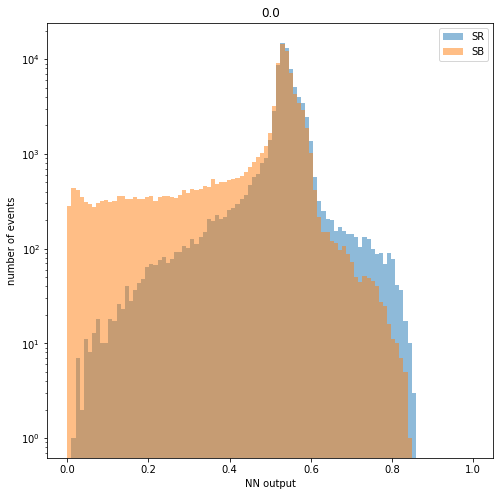

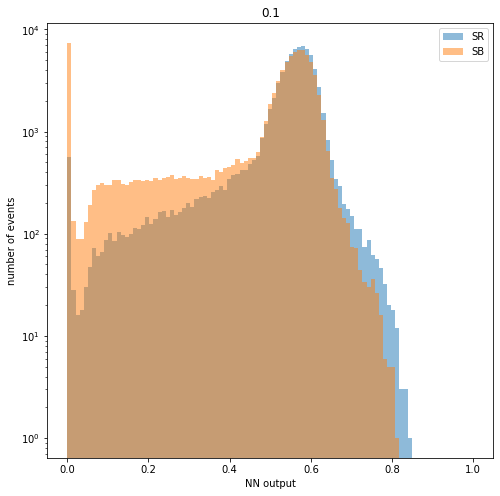

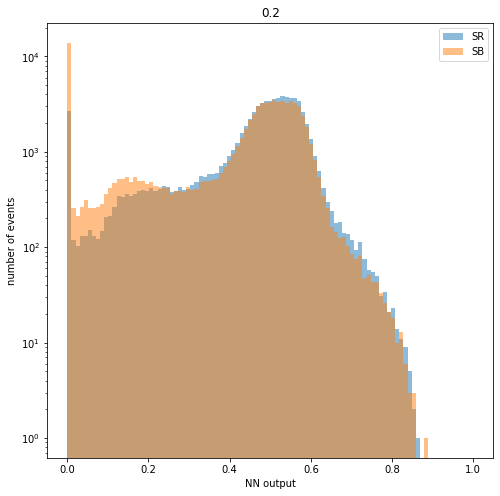

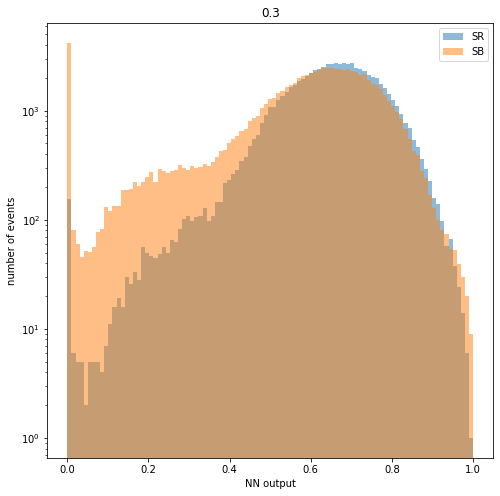

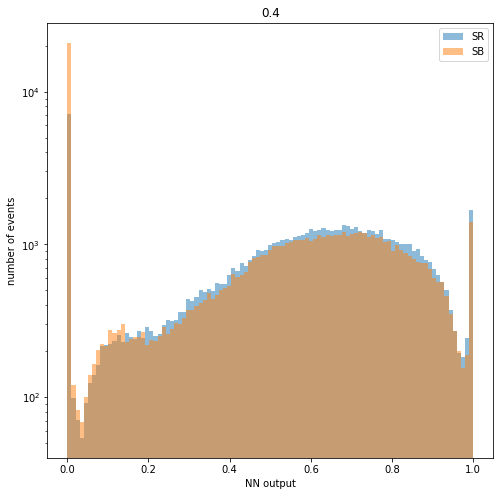

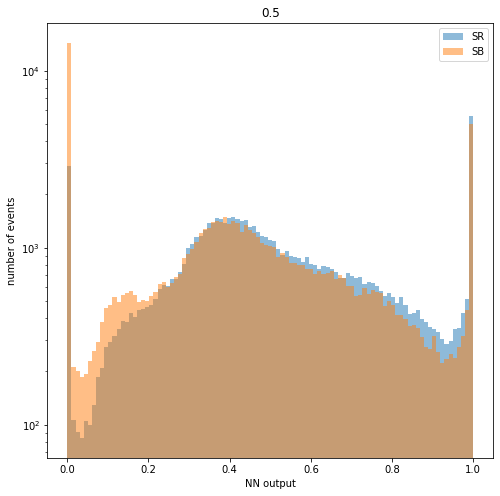

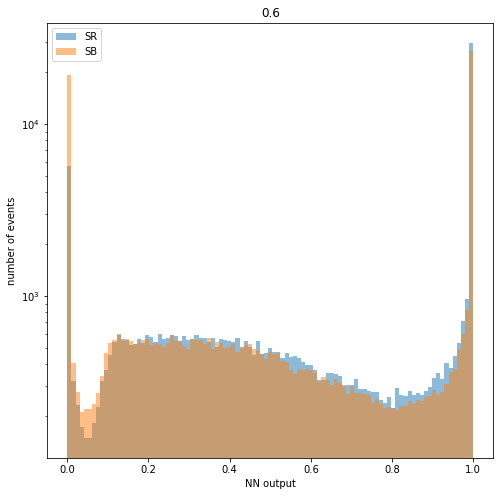

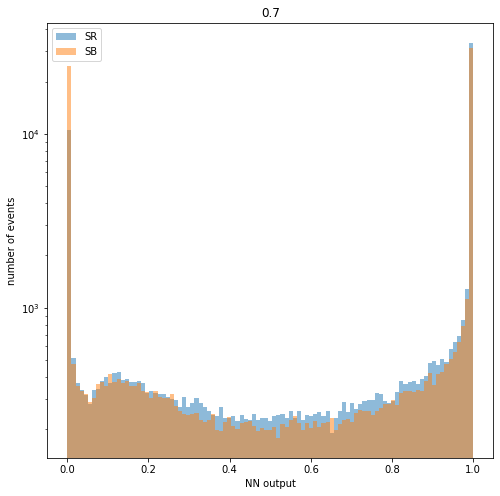

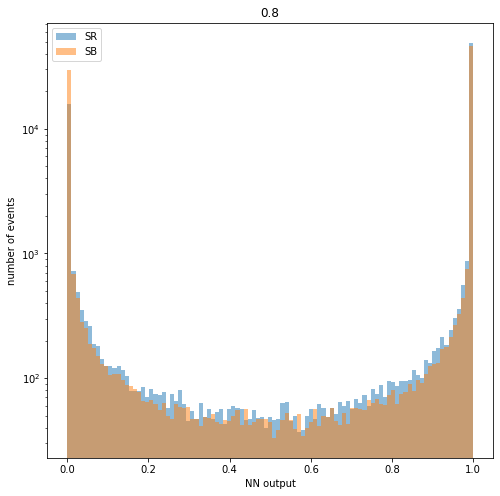

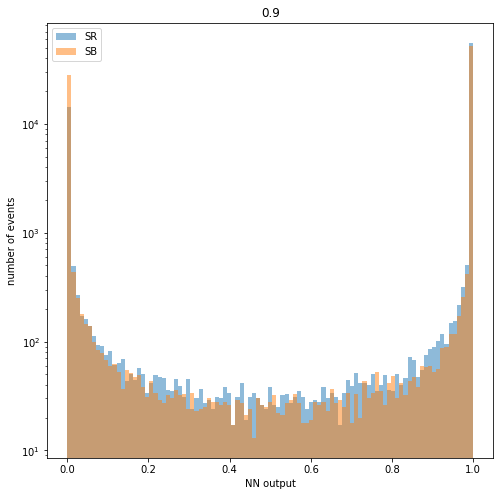

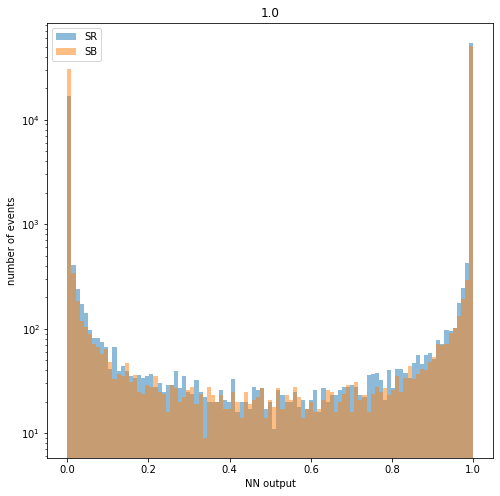

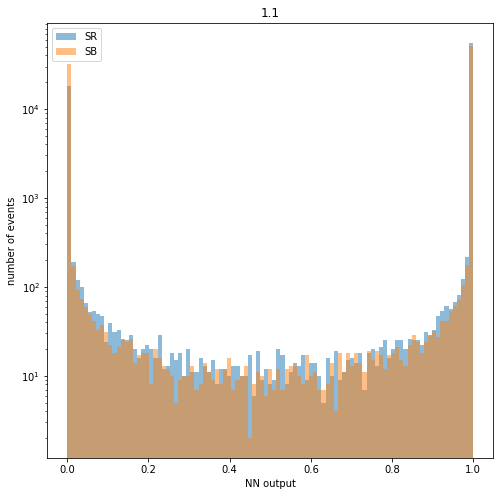

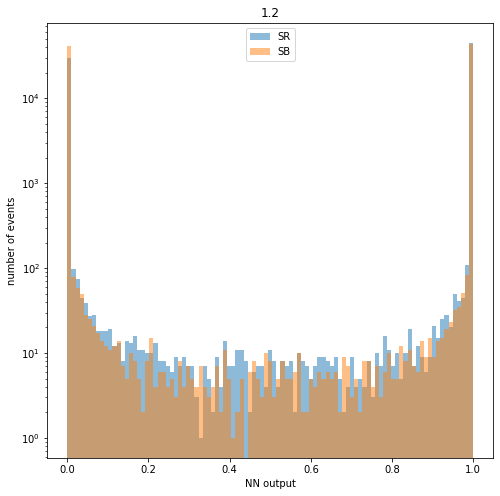

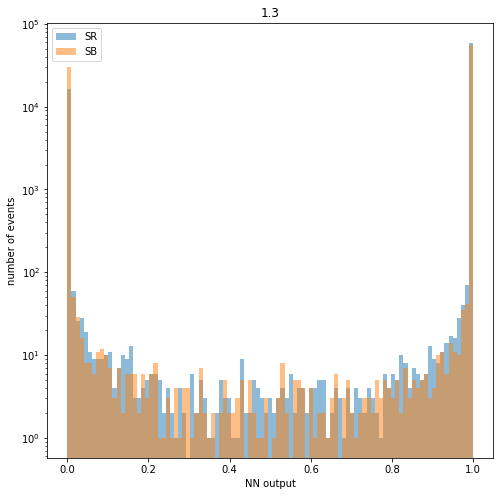

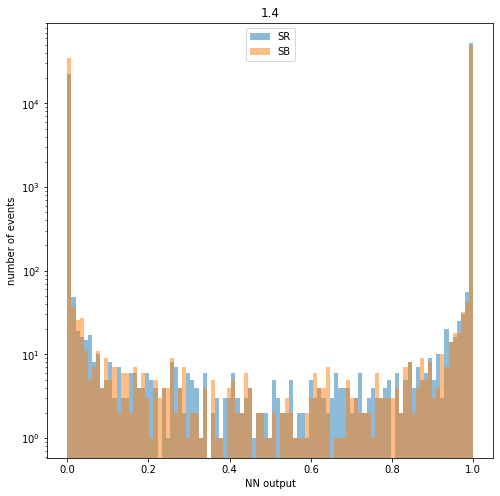

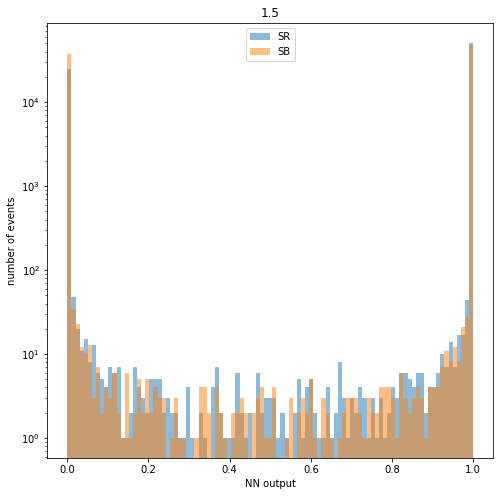

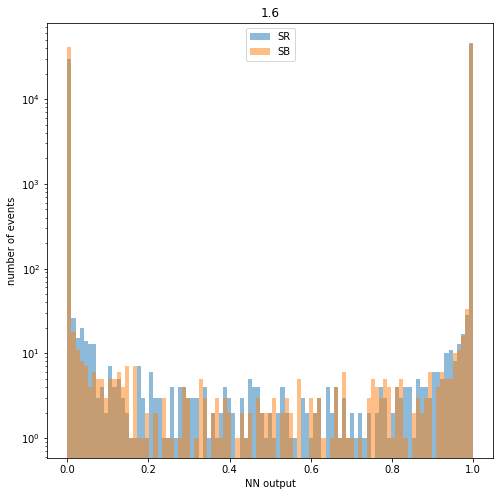

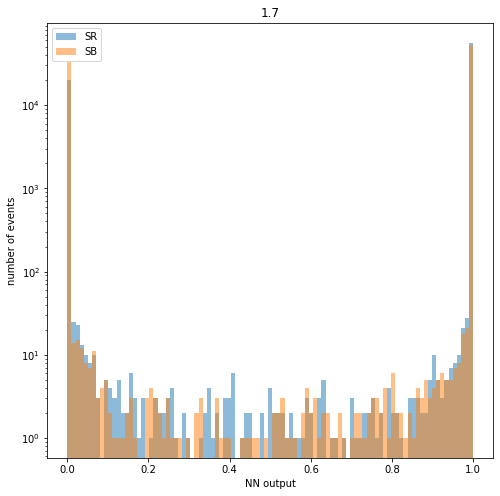

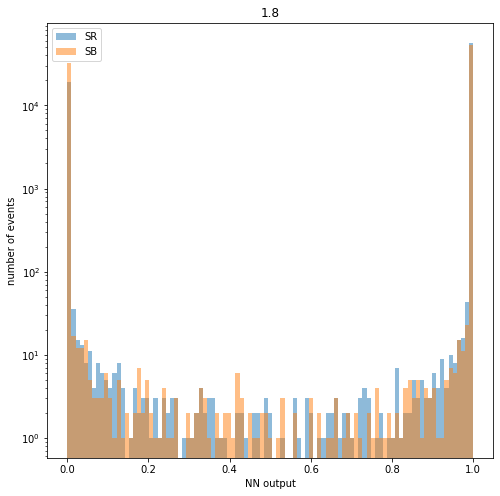

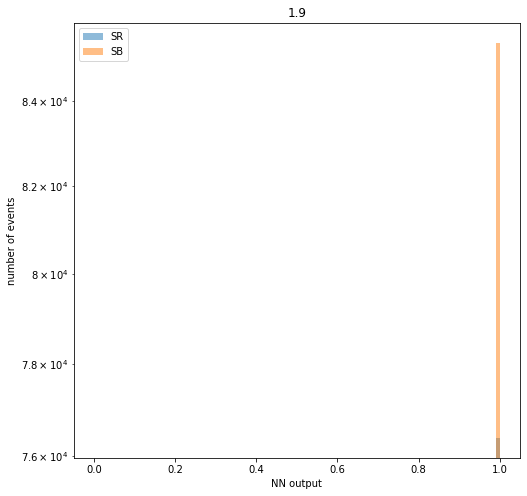

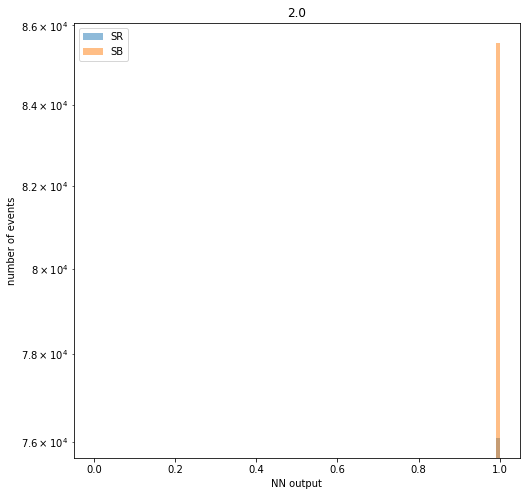

In [17]:
myaucs2 = []
histories2 = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    X = np.concatenate([x_SR_data,x_SB_data,x_SB_low_data,x_SB_high_data])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SB_low_data)),np.zeros(len(x_SB_high_data))])
    w_SR = 1.
    w_SB = len(x_SR_data)/len(x_SB_data)
    w_SB_low = len(x_SR_data)/len(x_SB_low_data)
    w_SB_high = len(x_SR_data)/len(x_SB_high_data)
    print(w_SR,w_SB,w_SB_low,w_SB_high)
    W = np.concatenate([w_SR*np.ones(len(x_SR_data)),w_SB*np.ones(len(x_SB_data)),-mylambda*w_SB_low*np.ones(len(x_SB_low_data)),-mylambda*w_SB_high*np.ones(len(x_SB_high_data))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

    histories2+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)

    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs2+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()

Text(0.5, 0, '$\\lambda$')

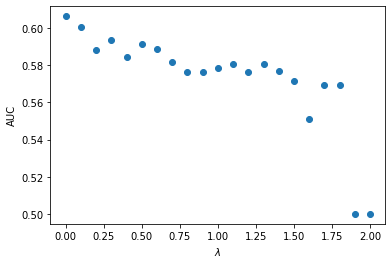

In [20]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs2,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")
#plt.xlim([0,1])

In [ ]:
#Now, try with signal injected to make sure that is preserved.

In [26]:
mylambda = 0.
X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC,x_SR_signal,x_SB_signal])
Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.zeros(len(x_SB_signal))])
W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.ones(len(x_SB_signal))])
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

preds_SR = model.predict(np.concatenate([x_SR_data,x_SB_signal]),batch_size=200)

Train on 370845 samples, validate on 370845 samples
Epoch 1/20
370845/370845 [==============================] - 19s 52us/step - loss: 0.6179 - acc: 0.5684 - val_loss: 0.6066 - val_acc: 0.5791
Epoch 2/20
370845/370845 [==============================] - 17s 45us/step - loss: 0.6000 - acc: 0.5931 - val_loss: 0.5956 - val_acc: 0.5966
Epoch 3/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5960 - acc: 0.5974 - val_loss: 0.5931 - val_acc: 0.5927
Epoch 4/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5951 - acc: 0.5991 - val_loss: 0.5917 - val_acc: 0.6048
Epoch 5/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5945 - acc: 0.5987 - val_loss: 0.5950 - val_acc: 0.6011
Epoch 6/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5943 - acc: 0.5996 - val_loss: 0.5912 - val_acc: 0.6014
Epoch 7/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5935 - acc: 0.6002 - val

ValueError: continuous format is not supported

In [35]:
fpr, tpr, thresholds_norotate = roc_curve(np.concatenate([np.zeros(len(x_SR_data)),np.ones(len(x_SB_signal))]),preds_SR[:,0])

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


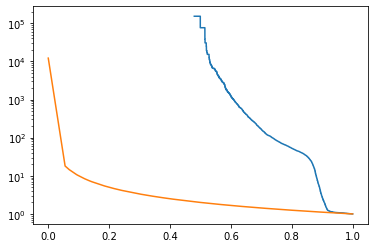

In [40]:
plt.plot(tpr,1./fpr)
plt.plot(tpr,1./tpr)
plt.yscale("log")